In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from catboost import CatBoostRegressor
from tqdm import tqdm

warnings.filterwarnings('ignore')

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
sample_submission = pd.read_csv("./data/sample_submission.csv")
age_gender_info = pd.read_csv("./data/age_gender_info.csv")
age_gender_spec = pd.DataFrame(age_gender_info['지역'])
population = pd.read_csv('./data/population.csv')
population.columns = ['지역','인구수']
age_gender_spec['2050'] = age_gender_info[['20대(남자)','20대(여자)','30대(남자)','30대(여자)',
                                          '40대(남자)','40대(여자)', '50대(남자)', '50대(여자)']].sum(axis=1)
age_gender_spec['5070'] = age_gender_info[['50대(남자)','50대(여자)',
                                          '60대(남자)','60대(여자)','70대(남자)','70대(여자)']].sum(axis=1)
age_gender_spec = age_gender_spec.merge(population, on='지역')
age_gender_spec['인구수_2050'] = np.round(age_gender_spec['2050']*age_gender_spec['인구수'])
# age_gender_spec['4050'] = age_gender_info[['40대(남자)','40대(여자)','50대(남자)','50대(여자)']].sum(axis=1)
# age_gender_spec['6070'] = age_gender_info[['60대(남자)','60대(여자)','70대(남자)','70대(여자)']].sum(axis=1)
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '등록차량수'
]

test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수'
]

categorial_variable = ["임대건물구분", "지역", "공급유형", "자격유형"]
continious_variable = ["총세대수", "전용면적", "전용면적별세대수", "공가수", "임대보증금", "임대료",
                       "단지내주차면수"]


age_gender_spec
# test_x_unique
# gbr: 72.57647194273466
# rfr: 19.73668358714044
# {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100} -62.07652539964124
# 144.17 143.65

,지역,2050,5070,인구수,인구수_2050
0,경상북도,0.546529,0.383757,2632401,1438683.0
1,경상남도,0.553635,0.397839,3325840,1841303.0
2,대전광역시,0.557744,0.401451,1456107,812135.0
3,경기도,0.563179,0.350007,13500688,7603308.0
4,전라북도,0.534647,0.387240,1794345,959341.0
5,강원도,0.541319,0.398374,1535530,831212.0
6,광주광역시,0.569820,0.363166,1442647,822049.0
7,충청남도,0.573740,0.347414,2117400,1214836.0
8,부산광역시,0.481420,0.478476,3364358,1619669.0
9,제주특별자치도,0.548047,0.368296,675293,370092.0


In [3]:
def sorter(column):
    test_index = pd.Categorical(column,categories=pd.unique(test['단지코드']),ordered=True)
    return pd.Series(test_index)


def pre_processing(x, flag):
    x = x.fillna(0)
    x.loc[x['임대료'] == '-', ['임대료']] = 0
    x.loc[x['임대보증금'] == '-', ['임대보증금']] = 0
    x[['임대료', '임대보증금']] = x[['임대료', '임대보증금']].astype('int64')

    x['전용면적'] = x['전용면적'] // 5 * 5
    idx = x[x['전용면적'] > 100].index
    x.loc[idx, '전용면적'] = 100
    idx = x[x['전용면적'] < 15].index
    x.loc[idx, '전용면적'] = 15
    columns = ['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철', '버스', '공급유형', '임대건물구분', '자격유형']
    target = "등록차량수"
    area_columns = []
    for area in x['전용면적'].unique():
        area_columns.append(f'면적_{area}')

    new_x = pd.DataFrame()
    for i, code in tqdm(enumerate(x['단지코드'].unique())):
        temp = x[x['단지코드'] == code]
        temp.index = range(temp.shape[0])
        for col in columns:
            new_x.loc[i, col] = temp.loc[0, col]

        for col in area_columns:
            area = float(col.split('_')[-1])
            new_x.loc[i, col] = temp[temp['전용면적'] == area]['전용면적별세대수'].sum()

        if flag == True:
            new_x.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']
    
    new_x = new_x.merge(age_gender_spec[['지역','인구수_2050']], on='지역', sort=False)
    new_x = pd.get_dummies(new_x, columns=categorial_variable)
    new_x = new_x[[c for c in new_x if c not in ['등록차량수']] + [c for c in ['등록차량수'] if c in new_x]]
    # scaler = RobustScaler()
    # x[continious_variable] = scaler.fit_transform(x[continious_variable])
    return new_x

differ_variables = ['공급유형_공공임대(5년)', '공급유형_공공임대(10년)', '자격유형_B', '자격유형_F',
                    '지역_서울특별시', '공급유형_공공분양', '공급유형_장기전세', '자격유형_D',
                    '면적_65.0']

if len(test[test['자격유형'].isnull() == True]) > 0:
    test.loc[test['자격유형'].isnull() == True, ['자격유형']] = ('A', 'C')

new_train = pre_processing(train, True)
new_test = pre_processing(test, False)


423it [00:07, 60.27it/s]
150it [00:02, 63.04it/s]


In [4]:
new_test = new_test.sort_values(by="단지코드", key=sorter)
for c in differ_variables:
    new_test[c] = 0

x_train = new_train.iloc[:, 1:-1]
y_train = new_train.iloc[:, -1]
x_test = new_test.iloc[:, 1:]

rfr = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=1,
                            min_samples_split=4, random_state=46)
cbr = CatBoostRegressor(loss_function='MAE', random_state=44)
model = cbr
train_X, test_X, train_y, test_y = train_test_split(x_train, y_train, test_size=0.2, random_state=93)

new_test

,단지코드,총세대수,공가수,단지내주차면수,지하철,버스,면적_35.0,면적_45.0,면적_50.0,면적_30.0,...,자격유형_M,자격유형_N,공급유형_공공임대(5년),자격유형_B,자격유형_F,지역_서울특별시,공급유형_공공분양,공급유형_장기전세,자격유형_D,면적_65.0
0,C1072,754.0,14.0,683.0,0.0,2.0,116.0,262.0,376.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,C1128,1354.0,9.0,1216.0,0.0,3.0,420.0,356.0,578.0,0.0,...,0,0,0,0,0,0,0,0,0,0
36,C1456,619.0,18.0,547.0,0.0,16.0,165.0,196.0,132.0,82.0,...,0,0,0,0,0,0,0,0,0,0
44,C1840,593.0,7.0,543.0,0.0,3.0,335.0,174.0,84.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,C1332,1297.0,11.0,1112.0,0.0,2.0,425.0,568.0,304.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,C2456,349.0,17.0,270.0,0.0,4.0,138.0,96.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
129,C1266,596.0,35.0,593.0,0.0,1.0,304.0,107.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
98,C2152,120.0,9.0,40.0,0.0,1.0,0.0,0.0,0.0,54.0,...,0,0,0,0,0,0,0,0,0,0
66,C1267,675.0,38.0,467.0,0.0,1.0,126.0,180.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
model.fit(train_X, train_y)
pred = model.predict(test_X)
print(mean_absolute_error(test_y, pred))


0:	learn: 274.9194370	total: 2.09ms	remaining: 2.09s
1:	learn: 269.6271033	total: 4.2ms	remaining: 2.1s
2:	learn: 264.4404674	total: 6.05ms	remaining: 2.01s
3:	learn: 260.3084657	total: 7.76ms	remaining: 1.93s
4:	learn: 255.3975554	total: 9.43ms	remaining: 1.88s
5:	learn: 250.9198116	total: 11.1ms	remaining: 1.84s
6:	learn: 246.3318962	total: 13ms	remaining: 1.85s
7:	learn: 242.3544424	total: 14.6ms	remaining: 1.81s
8:	learn: 238.0390632	total: 16.1ms	remaining: 1.78s
9:	learn: 233.8873317	total: 18ms	remaining: 1.78s
10:	learn: 230.0069104	total: 19.8ms	remaining: 1.78s
11:	learn: 226.6813581	total: 21.7ms	remaining: 1.78s
12:	learn: 222.6107232	total: 23.3ms	remaining: 1.77s
13:	learn: 218.8353874	total: 25.1ms	remaining: 1.76s
14:	learn: 215.4971779	total: 26.7ms	remaining: 1.75s
15:	learn: 212.1986447	total: 28.3ms	remaining: 1.74s
16:	learn: 209.0000616	total: 29.8ms	remaining: 1.73s
17:	learn: 206.3067095	total: 31.8ms	remaining: 1.73s
18:	learn: 203.8528864	total: 33.6ms	remaini

206:	learn: 75.5990450	total: 319ms	remaining: 1.22s
207:	learn: 75.2819116	total: 321ms	remaining: 1.22s
208:	learn: 75.1545762	total: 322ms	remaining: 1.22s
209:	learn: 75.0688371	total: 324ms	remaining: 1.22s
210:	learn: 74.8498477	total: 326ms	remaining: 1.22s
211:	learn: 74.6425422	total: 328ms	remaining: 1.22s
212:	learn: 74.4533112	total: 330ms	remaining: 1.22s
213:	learn: 74.2080724	total: 331ms	remaining: 1.22s
214:	learn: 73.9808733	total: 333ms	remaining: 1.22s
215:	learn: 73.8585939	total: 335ms	remaining: 1.21s
216:	learn: 73.5970577	total: 337ms	remaining: 1.22s
217:	learn: 73.3842544	total: 340ms	remaining: 1.22s
218:	learn: 73.2658286	total: 342ms	remaining: 1.22s
219:	learn: 73.1279680	total: 344ms	remaining: 1.22s
220:	learn: 72.8318262	total: 346ms	remaining: 1.22s
221:	learn: 72.7000841	total: 347ms	remaining: 1.22s
222:	learn: 72.5303968	total: 349ms	remaining: 1.21s
223:	learn: 72.4127449	total: 350ms	remaining: 1.21s
224:	learn: 72.0805106	total: 351ms	remaining:

409:	learn: 49.6273426	total: 631ms	remaining: 908ms
410:	learn: 49.5301822	total: 633ms	remaining: 907ms
411:	learn: 49.5257676	total: 635ms	remaining: 906ms
412:	learn: 49.4972385	total: 636ms	remaining: 904ms
413:	learn: 49.3570999	total: 638ms	remaining: 903ms
414:	learn: 49.2788657	total: 640ms	remaining: 902ms
415:	learn: 49.2007460	total: 642ms	remaining: 902ms
416:	learn: 49.1780576	total: 644ms	remaining: 900ms
417:	learn: 49.1283648	total: 645ms	remaining: 898ms
418:	learn: 49.0078731	total: 647ms	remaining: 897ms
419:	learn: 48.9516685	total: 648ms	remaining: 895ms
420:	learn: 48.8729338	total: 650ms	remaining: 894ms
421:	learn: 48.8455876	total: 652ms	remaining: 892ms
422:	learn: 48.8097646	total: 653ms	remaining: 891ms
423:	learn: 48.7389818	total: 655ms	remaining: 890ms
424:	learn: 48.6804379	total: 656ms	remaining: 888ms
425:	learn: 48.6224714	total: 658ms	remaining: 886ms
426:	learn: 48.5663151	total: 659ms	remaining: 885ms
427:	learn: 48.5206838	total: 661ms	remaining:

599:	learn: 38.8761007	total: 944ms	remaining: 629ms
600:	learn: 38.8425689	total: 945ms	remaining: 628ms
601:	learn: 38.8329808	total: 947ms	remaining: 626ms
602:	learn: 38.8058792	total: 949ms	remaining: 625ms
603:	learn: 38.7197169	total: 951ms	remaining: 623ms
604:	learn: 38.7121677	total: 952ms	remaining: 622ms
605:	learn: 38.6795201	total: 954ms	remaining: 620ms
606:	learn: 38.5784184	total: 956ms	remaining: 619ms
607:	learn: 38.5331632	total: 957ms	remaining: 617ms
608:	learn: 38.4475098	total: 958ms	remaining: 615ms
609:	learn: 38.3611469	total: 960ms	remaining: 614ms
610:	learn: 38.2777028	total: 961ms	remaining: 612ms
611:	learn: 38.2209000	total: 962ms	remaining: 610ms
612:	learn: 38.1931054	total: 964ms	remaining: 608ms
613:	learn: 38.1187903	total: 965ms	remaining: 607ms
614:	learn: 38.0970270	total: 967ms	remaining: 605ms
615:	learn: 38.0195325	total: 968ms	remaining: 604ms
616:	learn: 37.9766793	total: 970ms	remaining: 602ms
617:	learn: 37.9141909	total: 971ms	remaining:

805:	learn: 31.0151634	total: 1.26s	remaining: 303ms
806:	learn: 30.9973530	total: 1.26s	remaining: 301ms
807:	learn: 30.9903529	total: 1.26s	remaining: 300ms
808:	learn: 30.9642313	total: 1.26s	remaining: 298ms
809:	learn: 30.9421074	total: 1.26s	remaining: 297ms
810:	learn: 30.9095906	total: 1.27s	remaining: 295ms
811:	learn: 30.8680492	total: 1.27s	remaining: 293ms
812:	learn: 30.8528256	total: 1.27s	remaining: 292ms
813:	learn: 30.8240420	total: 1.27s	remaining: 290ms
814:	learn: 30.8123508	total: 1.27s	remaining: 289ms
815:	learn: 30.7960670	total: 1.27s	remaining: 287ms
816:	learn: 30.7682369	total: 1.27s	remaining: 286ms
817:	learn: 30.7600738	total: 1.28s	remaining: 284ms
818:	learn: 30.7034141	total: 1.28s	remaining: 282ms
819:	learn: 30.6778249	total: 1.28s	remaining: 281ms
820:	learn: 30.6474948	total: 1.28s	remaining: 279ms
821:	learn: 30.6378927	total: 1.28s	remaining: 278ms
822:	learn: 30.6328947	total: 1.28s	remaining: 276ms
823:	learn: 30.5874846	total: 1.29s	remaining:

130.96985142689712


In [5]:
cv_score = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
print(np.mean(cv_score * -1))


128.85756053023357


In [82]:
params = {
        'n_estimators': [200],
        'max_depth': [15],
        'min_samples_leaf': [1],
        'min_samples_split': [4],
    }

cat_params = {
    'random_state':range(1,100)
}
grid = GridSearchCV(model, param_grid=cat_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(x_train, y_train)
pred = grid.predict(x_test)

print(grid.best_params_, grid.best_score_)


0:	learn: 283.6134034	total: 2.55ms	remaining: 2.54s
1:	learn: 277.5275574	total: 4.85ms	remaining: 2.42s
2:	learn: 272.3738876	total: 6.93ms	remaining: 2.3s
3:	learn: 266.8605380	total: 9.39ms	remaining: 2.34s
4:	learn: 261.7823227	total: 11.8ms	remaining: 2.35s
5:	learn: 256.1617621	total: 13.7ms	remaining: 2.27s
6:	learn: 251.1622179	total: 16.1ms	remaining: 2.29s
7:	learn: 247.4472983	total: 18.3ms	remaining: 2.26s
8:	learn: 243.3759991	total: 20.7ms	remaining: 2.28s
9:	learn: 238.9308107	total: 22.6ms	remaining: 2.24s
10:	learn: 235.1978988	total: 25.2ms	remaining: 2.26s
11:	learn: 231.7341244	total: 27.2ms	remaining: 2.23s
12:	learn: 227.9455796	total: 29.2ms	remaining: 2.22s
13:	learn: 224.9834392	total: 31.7ms	remaining: 2.23s
14:	learn: 221.2349653	total: 34.2ms	remaining: 2.25s
15:	learn: 217.3825446	total: 45.3ms	remaining: 2.79s
16:	learn: 213.9871657	total: 47.7ms	remaining: 2.76s
17:	learn: 211.0960443	total: 49.5ms	remaining: 2.7s
18:	learn: 207.9194449	total: 51.3ms	rem

227:	learn: 78.8937020	total: 471ms	remaining: 1.59s
228:	learn: 78.6942616	total: 473ms	remaining: 1.59s
229:	learn: 78.4725119	total: 476ms	remaining: 1.59s
230:	learn: 78.3126100	total: 478ms	remaining: 1.59s
231:	learn: 78.1388897	total: 480ms	remaining: 1.59s
232:	learn: 77.9221725	total: 483ms	remaining: 1.59s
233:	learn: 77.6701745	total: 485ms	remaining: 1.59s
234:	learn: 77.3905453	total: 487ms	remaining: 1.58s
235:	learn: 77.1053136	total: 489ms	remaining: 1.58s
236:	learn: 76.9271779	total: 491ms	remaining: 1.58s
237:	learn: 76.5680990	total: 493ms	remaining: 1.58s
238:	learn: 76.3895297	total: 495ms	remaining: 1.57s
239:	learn: 76.1216555	total: 497ms	remaining: 1.57s
240:	learn: 75.9069619	total: 499ms	remaining: 1.57s
241:	learn: 75.7648859	total: 501ms	remaining: 1.57s
242:	learn: 75.6947482	total: 503ms	remaining: 1.57s
243:	learn: 75.6175157	total: 505ms	remaining: 1.56s
244:	learn: 75.4837035	total: 507ms	remaining: 1.56s
245:	learn: 75.3793898	total: 509ms	remaining:

390:	learn: 56.6760333	total: 785ms	remaining: 1.22s
391:	learn: 56.5878537	total: 787ms	remaining: 1.22s
392:	learn: 56.5161439	total: 789ms	remaining: 1.22s
393:	learn: 56.4075386	total: 791ms	remaining: 1.22s
394:	learn: 56.2941816	total: 793ms	remaining: 1.22s
395:	learn: 56.2441426	total: 795ms	remaining: 1.21s
396:	learn: 56.1994329	total: 797ms	remaining: 1.21s
397:	learn: 56.1252988	total: 799ms	remaining: 1.21s
398:	learn: 56.0858642	total: 801ms	remaining: 1.21s
399:	learn: 56.0420896	total: 803ms	remaining: 1.2s
400:	learn: 56.0167584	total: 805ms	remaining: 1.2s
401:	learn: 55.9487169	total: 807ms	remaining: 1.2s
402:	learn: 55.8364308	total: 809ms	remaining: 1.2s
403:	learn: 55.8140002	total: 810ms	remaining: 1.2s
404:	learn: 55.7819386	total: 812ms	remaining: 1.19s
405:	learn: 55.6080604	total: 814ms	remaining: 1.19s
406:	learn: 55.5720066	total: 816ms	remaining: 1.19s
407:	learn: 55.4889296	total: 818ms	remaining: 1.19s
408:	learn: 55.4454806	total: 820ms	remaining: 1.18

554:	learn: 46.4601712	total: 1.1s	remaining: 881ms
555:	learn: 46.4227186	total: 1.1s	remaining: 879ms
556:	learn: 46.3702035	total: 1.1s	remaining: 877ms
557:	learn: 46.3615620	total: 1.1s	remaining: 875ms
558:	learn: 46.3037169	total: 1.11s	remaining: 874ms
559:	learn: 46.2231907	total: 1.11s	remaining: 872ms
560:	learn: 46.1356069	total: 1.11s	remaining: 870ms
561:	learn: 46.0479742	total: 1.11s	remaining: 868ms
562:	learn: 45.9774745	total: 1.11s	remaining: 865ms
563:	learn: 45.9086590	total: 1.12s	remaining: 864ms
564:	learn: 45.8503033	total: 1.12s	remaining: 862ms
565:	learn: 45.8031992	total: 1.12s	remaining: 860ms
566:	learn: 45.7565233	total: 1.12s	remaining: 857ms
567:	learn: 45.7082536	total: 1.12s	remaining: 855ms
568:	learn: 45.6277805	total: 1.13s	remaining: 853ms
569:	learn: 45.5778151	total: 1.13s	remaining: 851ms
570:	learn: 45.4491764	total: 1.13s	remaining: 849ms
571:	learn: 45.3830778	total: 1.13s	remaining: 847ms
572:	learn: 45.3214126	total: 1.13s	remaining: 845

719:	learn: 38.3228012	total: 1.41s	remaining: 550ms
720:	learn: 38.2779361	total: 1.42s	remaining: 548ms
721:	learn: 38.2563507	total: 1.42s	remaining: 546ms
722:	learn: 38.2320537	total: 1.42s	remaining: 544ms
723:	learn: 38.2008057	total: 1.42s	remaining: 542ms
724:	learn: 38.1506253	total: 1.42s	remaining: 540ms
725:	learn: 38.1224780	total: 1.43s	remaining: 538ms
726:	learn: 38.0846634	total: 1.43s	remaining: 536ms
727:	learn: 38.0556337	total: 1.43s	remaining: 535ms
728:	learn: 38.0218777	total: 1.43s	remaining: 533ms
729:	learn: 37.9888942	total: 1.43s	remaining: 531ms
730:	learn: 37.9525062	total: 1.44s	remaining: 529ms
731:	learn: 37.9354327	total: 1.44s	remaining: 527ms
732:	learn: 37.8701053	total: 1.44s	remaining: 525ms
733:	learn: 37.8375621	total: 1.44s	remaining: 523ms
734:	learn: 37.8118604	total: 1.44s	remaining: 521ms
735:	learn: 37.6797656	total: 1.45s	remaining: 519ms
736:	learn: 37.6725678	total: 1.45s	remaining: 517ms
737:	learn: 37.6491699	total: 1.45s	remaining:

884:	learn: 33.9534398	total: 1.73s	remaining: 225ms
885:	learn: 33.9470057	total: 1.73s	remaining: 223ms
886:	learn: 33.9463339	total: 1.73s	remaining: 221ms
887:	learn: 33.9252445	total: 1.74s	remaining: 219ms
888:	learn: 33.8941943	total: 1.74s	remaining: 217ms
889:	learn: 33.8676307	total: 1.74s	remaining: 215ms
890:	learn: 33.8600594	total: 1.74s	remaining: 213ms
891:	learn: 33.8567501	total: 1.74s	remaining: 211ms
892:	learn: 33.8378102	total: 1.75s	remaining: 209ms
893:	learn: 33.8154355	total: 1.75s	remaining: 207ms
894:	learn: 33.7661484	total: 1.75s	remaining: 205ms
895:	learn: 33.7336385	total: 1.75s	remaining: 203ms
896:	learn: 33.7132923	total: 1.75s	remaining: 201ms
897:	learn: 33.6913431	total: 1.75s	remaining: 199ms
898:	learn: 33.6731844	total: 1.76s	remaining: 197ms
899:	learn: 33.6402588	total: 1.76s	remaining: 196ms
900:	learn: 33.6323019	total: 1.76s	remaining: 194ms
901:	learn: 33.6086773	total: 1.76s	remaining: 192ms
902:	learn: 33.5950576	total: 1.76s	remaining:

In [11]:
model.fit(x_train, y_train)
df = pd.DataFrame()
df['column'] = x_train.columns
df['coef'] = model.feature_importances_
print(df.sort_values('coef', ascending=False).head(15))

0:	learn: 283.6134034	total: 11.3ms	remaining: 11.3s
1:	learn: 277.5275574	total: 13.1ms	remaining: 6.55s
2:	learn: 272.3738876	total: 14.9ms	remaining: 4.95s
3:	learn: 266.8605380	total: 16.7ms	remaining: 4.15s
4:	learn: 261.7823227	total: 18.5ms	remaining: 3.67s
5:	learn: 256.1617621	total: 20.1ms	remaining: 3.34s
6:	learn: 251.1622179	total: 22ms	remaining: 3.12s
7:	learn: 247.4472983	total: 23.9ms	remaining: 2.97s
8:	learn: 243.3759991	total: 25.7ms	remaining: 2.83s
9:	learn: 238.9308107	total: 27.5ms	remaining: 2.72s
10:	learn: 235.1657835	total: 29.2ms	remaining: 2.62s
11:	learn: 231.6792800	total: 31ms	remaining: 2.55s
12:	learn: 227.8923178	total: 32.7ms	remaining: 2.48s
13:	learn: 224.9491224	total: 34.9ms	remaining: 2.46s
14:	learn: 221.2098569	total: 37.3ms	remaining: 2.45s
15:	learn: 217.3478255	total: 40.7ms	remaining: 2.5s
16:	learn: 213.9501331	total: 43.1ms	remaining: 2.49s
17:	learn: 211.0705576	total: 45.2ms	remaining: 2.47s
18:	learn: 207.9003645	total: 47.2ms	remain

186:	learn: 85.8465507	total: 329ms	remaining: 1.43s
187:	learn: 85.5822737	total: 331ms	remaining: 1.43s
188:	learn: 85.3469602	total: 333ms	remaining: 1.43s
189:	learn: 85.0702343	total: 335ms	remaining: 1.43s
190:	learn: 84.8325401	total: 338ms	remaining: 1.43s
191:	learn: 84.5429492	total: 340ms	remaining: 1.43s
192:	learn: 84.3952905	total: 342ms	remaining: 1.43s
193:	learn: 84.2138947	total: 344ms	remaining: 1.43s
194:	learn: 84.0601516	total: 347ms	remaining: 1.43s
195:	learn: 83.8584444	total: 349ms	remaining: 1.43s
196:	learn: 83.6614034	total: 351ms	remaining: 1.43s
197:	learn: 83.5097393	total: 354ms	remaining: 1.43s
198:	learn: 83.0053723	total: 356ms	remaining: 1.43s
199:	learn: 82.8224603	total: 358ms	remaining: 1.43s
200:	learn: 82.7185388	total: 360ms	remaining: 1.43s
201:	learn: 82.4486173	total: 362ms	remaining: 1.43s
202:	learn: 82.2817440	total: 364ms	remaining: 1.43s
203:	learn: 82.0836901	total: 367ms	remaining: 1.43s
204:	learn: 81.9121365	total: 369ms	remaining:

365:	learn: 59.0674856	total: 645ms	remaining: 1.12s
366:	learn: 58.9764050	total: 646ms	remaining: 1.11s
367:	learn: 58.9084462	total: 648ms	remaining: 1.11s
368:	learn: 58.8426778	total: 650ms	remaining: 1.11s
369:	learn: 58.7870501	total: 653ms	remaining: 1.11s
370:	learn: 58.6683341	total: 654ms	remaining: 1.11s
371:	learn: 58.5944520	total: 656ms	remaining: 1.11s
372:	learn: 58.4456551	total: 658ms	remaining: 1.1s
373:	learn: 58.3595503	total: 659ms	remaining: 1.1s
374:	learn: 58.3245331	total: 661ms	remaining: 1.1s
375:	learn: 58.2650426	total: 662ms	remaining: 1.1s
376:	learn: 58.1248951	total: 664ms	remaining: 1.1s
377:	learn: 58.0581120	total: 666ms	remaining: 1.09s
378:	learn: 57.9060775	total: 667ms	remaining: 1.09s
379:	learn: 57.8363864	total: 669ms	remaining: 1.09s
380:	learn: 57.7583036	total: 670ms	remaining: 1.09s
381:	learn: 57.5524843	total: 672ms	remaining: 1.09s
382:	learn: 57.3501031	total: 674ms	remaining: 1.08s
383:	learn: 57.2671489	total: 675ms	remaining: 1.08

535:	learn: 46.6589222	total: 964ms	remaining: 834ms
536:	learn: 46.6250902	total: 966ms	remaining: 833ms
537:	learn: 46.6054349	total: 968ms	remaining: 832ms
538:	learn: 46.5045715	total: 971ms	remaining: 831ms
539:	learn: 46.3751377	total: 975ms	remaining: 830ms
540:	learn: 46.2832943	total: 977ms	remaining: 829ms
541:	learn: 46.1886471	total: 980ms	remaining: 828ms
542:	learn: 46.1802653	total: 981ms	remaining: 826ms
543:	learn: 46.0455371	total: 984ms	remaining: 825ms
544:	learn: 46.0374664	total: 986ms	remaining: 823ms
545:	learn: 45.9959571	total: 988ms	remaining: 822ms
546:	learn: 45.9343832	total: 991ms	remaining: 820ms
547:	learn: 45.9012541	total: 993ms	remaining: 819ms
548:	learn: 45.8084603	total: 995ms	remaining: 817ms
549:	learn: 45.6955585	total: 997ms	remaining: 816ms
550:	learn: 45.6175818	total: 999ms	remaining: 814ms
551:	learn: 45.5689175	total: 1s	remaining: 812ms
552:	learn: 45.5522896	total: 1s	remaining: 811ms
553:	learn: 45.5229217	total: 1s	remaining: 810ms
55

711:	learn: 38.6233162	total: 1.28s	remaining: 518ms
712:	learn: 38.5900723	total: 1.28s	remaining: 517ms
713:	learn: 38.5557154	total: 1.28s	remaining: 515ms
714:	learn: 38.5510355	total: 1.29s	remaining: 513ms
715:	learn: 38.5492081	total: 1.29s	remaining: 511ms
716:	learn: 38.5464947	total: 1.29s	remaining: 510ms
717:	learn: 38.4777427	total: 1.29s	remaining: 508ms
718:	learn: 38.4359198	total: 1.29s	remaining: 506ms
719:	learn: 38.4302128	total: 1.3s	remaining: 504ms
720:	learn: 38.3841284	total: 1.3s	remaining: 502ms
721:	learn: 38.3445539	total: 1.3s	remaining: 500ms
722:	learn: 38.3353904	total: 1.3s	remaining: 498ms
723:	learn: 38.2976587	total: 1.3s	remaining: 496ms
724:	learn: 38.2595847	total: 1.3s	remaining: 495ms
725:	learn: 38.2429252	total: 1.3s	remaining: 493ms
726:	learn: 38.2106406	total: 1.31s	remaining: 491ms
727:	learn: 38.1786877	total: 1.31s	remaining: 489ms
728:	learn: 38.1659041	total: 1.31s	remaining: 487ms
729:	learn: 38.1361260	total: 1.31s	remaining: 485ms


904:	learn: 32.9792815	total: 1.6s	remaining: 168ms
905:	learn: 32.9710975	total: 1.6s	remaining: 166ms
906:	learn: 32.9594128	total: 1.6s	remaining: 164ms
907:	learn: 32.9405306	total: 1.6s	remaining: 163ms
908:	learn: 32.9211469	total: 1.61s	remaining: 161ms
909:	learn: 32.8897546	total: 1.61s	remaining: 159ms
910:	learn: 32.8757798	total: 1.61s	remaining: 157ms
911:	learn: 32.8621791	total: 1.61s	remaining: 156ms
912:	learn: 32.8180793	total: 1.61s	remaining: 154ms
913:	learn: 32.7890141	total: 1.62s	remaining: 152ms
914:	learn: 32.7527288	total: 1.62s	remaining: 150ms
915:	learn: 32.7468845	total: 1.62s	remaining: 149ms
916:	learn: 32.7419977	total: 1.62s	remaining: 147ms
917:	learn: 32.7288100	total: 1.62s	remaining: 145ms
918:	learn: 32.7187896	total: 1.63s	remaining: 143ms
919:	learn: 32.7153132	total: 1.63s	remaining: 142ms
920:	learn: 32.7114318	total: 1.63s	remaining: 140ms
921:	learn: 32.7017411	total: 1.63s	remaining: 138ms
922:	learn: 32.6945572	total: 1.63s	remaining: 136

In [7]:
model.fit(x_train, y_train)
pred = model.predict(x_test)
sample_submission['num'] = pred
sample_submission.to_csv('./result/result8_3.csv', index=False)

0:	learn: 283.6134034	total: 146ms	remaining: 2m 25s
1:	learn: 277.5275574	total: 149ms	remaining: 1m 14s
2:	learn: 272.3738876	total: 153ms	remaining: 50.9s
3:	learn: 266.8605380	total: 157ms	remaining: 39.1s
4:	learn: 261.7823227	total: 161ms	remaining: 31.9s
5:	learn: 256.1617621	total: 164ms	remaining: 27.2s
6:	learn: 251.1622179	total: 166ms	remaining: 23.5s
7:	learn: 247.4472983	total: 168ms	remaining: 20.8s
8:	learn: 243.3759991	total: 169ms	remaining: 18.7s
9:	learn: 238.9308107	total: 171ms	remaining: 16.9s
10:	learn: 235.1657835	total: 173ms	remaining: 15.5s
11:	learn: 231.6792800	total: 175ms	remaining: 14.4s
12:	learn: 227.8923178	total: 176ms	remaining: 13.4s
13:	learn: 224.9491224	total: 178ms	remaining: 12.5s
14:	learn: 221.2098569	total: 179ms	remaining: 11.8s
15:	learn: 217.3478255	total: 181ms	remaining: 11.2s
16:	learn: 213.9501331	total: 183ms	remaining: 10.6s
17:	learn: 211.0705576	total: 185ms	remaining: 10.1s
18:	learn: 207.9003645	total: 187ms	remaining: 9.64s
1

189:	learn: 85.0702343	total: 466ms	remaining: 1.99s
190:	learn: 84.8325401	total: 470ms	remaining: 1.99s
191:	learn: 84.5429492	total: 473ms	remaining: 1.99s
192:	learn: 84.3952905	total: 475ms	remaining: 1.99s
193:	learn: 84.2138947	total: 477ms	remaining: 1.98s
194:	learn: 84.0601516	total: 479ms	remaining: 1.98s
195:	learn: 83.8584444	total: 480ms	remaining: 1.97s
196:	learn: 83.6614034	total: 482ms	remaining: 1.97s
197:	learn: 83.5097393	total: 484ms	remaining: 1.96s
198:	learn: 83.0053723	total: 486ms	remaining: 1.96s
199:	learn: 82.8224603	total: 488ms	remaining: 1.95s
200:	learn: 82.7185388	total: 490ms	remaining: 1.95s
201:	learn: 82.4486173	total: 492ms	remaining: 1.94s
202:	learn: 82.2817440	total: 493ms	remaining: 1.94s
203:	learn: 82.0836901	total: 495ms	remaining: 1.93s
204:	learn: 81.9121365	total: 496ms	remaining: 1.92s
205:	learn: 81.6866403	total: 498ms	remaining: 1.92s
206:	learn: 81.3642567	total: 499ms	remaining: 1.91s
207:	learn: 81.0226108	total: 501ms	remaining:

369:	learn: 58.7870501	total: 782ms	remaining: 1.33s
370:	learn: 58.6683341	total: 784ms	remaining: 1.33s
371:	learn: 58.5944520	total: 786ms	remaining: 1.33s
372:	learn: 58.4456551	total: 788ms	remaining: 1.32s
373:	learn: 58.3595503	total: 790ms	remaining: 1.32s
374:	learn: 58.3245331	total: 792ms	remaining: 1.32s
375:	learn: 58.2650426	total: 793ms	remaining: 1.32s
376:	learn: 58.1248951	total: 795ms	remaining: 1.31s
377:	learn: 58.0581120	total: 797ms	remaining: 1.31s
378:	learn: 57.9060775	total: 799ms	remaining: 1.31s
379:	learn: 57.8363864	total: 801ms	remaining: 1.31s
380:	learn: 57.7583036	total: 802ms	remaining: 1.3s
381:	learn: 57.5524843	total: 804ms	remaining: 1.3s
382:	learn: 57.3501031	total: 805ms	remaining: 1.3s
383:	learn: 57.2671489	total: 807ms	remaining: 1.29s
384:	learn: 57.1259633	total: 809ms	remaining: 1.29s
385:	learn: 56.9322255	total: 810ms	remaining: 1.29s
386:	learn: 56.8596114	total: 812ms	remaining: 1.28s
387:	learn: 56.8064800	total: 815ms	remaining: 1.

539:	learn: 46.3751377	total: 1.1s	remaining: 934ms
540:	learn: 46.2832943	total: 1.1s	remaining: 932ms
541:	learn: 46.1886471	total: 1.1s	remaining: 929ms
542:	learn: 46.1802653	total: 1.1s	remaining: 927ms
543:	learn: 46.0455371	total: 1.1s	remaining: 925ms
544:	learn: 46.0374664	total: 1.1s	remaining: 922ms
545:	learn: 45.9959571	total: 1.11s	remaining: 921ms
546:	learn: 45.9343832	total: 1.11s	remaining: 919ms
547:	learn: 45.9012541	total: 1.11s	remaining: 917ms
548:	learn: 45.8084603	total: 1.11s	remaining: 915ms
549:	learn: 45.6955585	total: 1.11s	remaining: 913ms
550:	learn: 45.6175818	total: 1.12s	remaining: 910ms
551:	learn: 45.5689175	total: 1.12s	remaining: 908ms
552:	learn: 45.5522896	total: 1.12s	remaining: 906ms
553:	learn: 45.5229217	total: 1.12s	remaining: 905ms
554:	learn: 45.4868602	total: 1.13s	remaining: 902ms
555:	learn: 45.4260025	total: 1.13s	remaining: 900ms
556:	learn: 45.4190199	total: 1.13s	remaining: 898ms
557:	learn: 45.3990139	total: 1.13s	remaining: 896ms

709:	learn: 38.7608863	total: 1.41s	remaining: 575ms
710:	learn: 38.7112309	total: 1.41s	remaining: 573ms
711:	learn: 38.6233162	total: 1.41s	remaining: 571ms
712:	learn: 38.5900723	total: 1.41s	remaining: 569ms
713:	learn: 38.5557154	total: 1.42s	remaining: 567ms
714:	learn: 38.5510355	total: 1.42s	remaining: 565ms
715:	learn: 38.5492081	total: 1.42s	remaining: 563ms
716:	learn: 38.5464947	total: 1.42s	remaining: 561ms
717:	learn: 38.4777427	total: 1.42s	remaining: 559ms
718:	learn: 38.4359198	total: 1.42s	remaining: 557ms
719:	learn: 38.4302128	total: 1.43s	remaining: 555ms
720:	learn: 38.3841284	total: 1.43s	remaining: 553ms
721:	learn: 38.3445539	total: 1.43s	remaining: 551ms
722:	learn: 38.3353904	total: 1.43s	remaining: 549ms
723:	learn: 38.2976587	total: 1.43s	remaining: 546ms
724:	learn: 38.2595847	total: 1.44s	remaining: 544ms
725:	learn: 38.2429252	total: 1.44s	remaining: 542ms
726:	learn: 38.2106406	total: 1.44s	remaining: 540ms
727:	learn: 38.1786877	total: 1.44s	remaining:

887:	learn: 33.4848760	total: 1.73s	remaining: 218ms
888:	learn: 33.4678060	total: 1.73s	remaining: 216ms
889:	learn: 33.4602761	total: 1.73s	remaining: 214ms
890:	learn: 33.4283465	total: 1.73s	remaining: 212ms
891:	learn: 33.4004689	total: 1.73s	remaining: 210ms
892:	learn: 33.3833922	total: 1.74s	remaining: 208ms
893:	learn: 33.3134476	total: 1.74s	remaining: 206ms
894:	learn: 33.2947494	total: 1.74s	remaining: 204ms
895:	learn: 33.2707664	total: 1.74s	remaining: 202ms
896:	learn: 33.2217843	total: 1.74s	remaining: 200ms
897:	learn: 33.1805476	total: 1.75s	remaining: 198ms
898:	learn: 33.1664941	total: 1.75s	remaining: 196ms
899:	learn: 33.0579134	total: 1.75s	remaining: 194ms
900:	learn: 33.0506871	total: 1.75s	remaining: 192ms
901:	learn: 33.0380085	total: 1.75s	remaining: 190ms
902:	learn: 33.0300919	total: 1.75s	remaining: 188ms
903:	learn: 33.0209067	total: 1.75s	remaining: 186ms
904:	learn: 32.9792815	total: 1.76s	remaining: 184ms
905:	learn: 32.9710975	total: 1.76s	remaining:

25.82978061625275


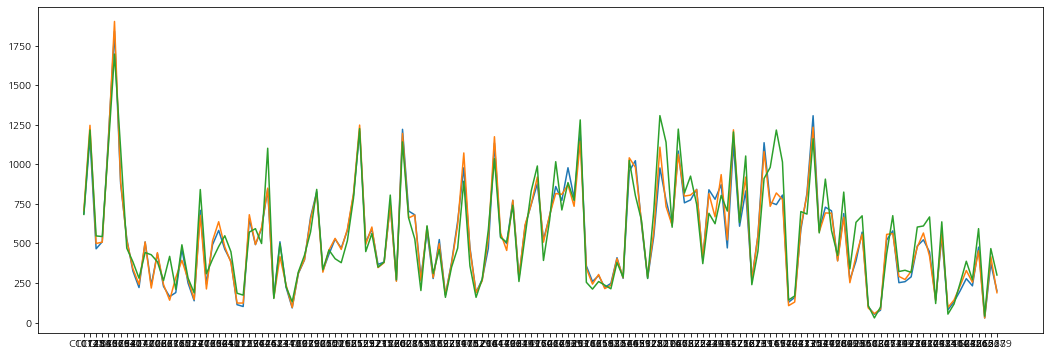

,code,num_x,num_y,danji_score,sub_score
5,C1563,1839.424899,1901.993825,1696.0,205.993825
6,C1794,876.668847,892.384693,1098.0,205.615307
11,C1006,235.927440,217.622501,428.0,210.377499
14,C2676,163.765820,140.966655,418.0,277.033345
19,C2411,708.967307,676.926410,840.0,163.073590
21,C1604,491.467246,516.766614,400.0,116.766614
22,C2535,581.975577,636.692080,480.0,156.692080
27,C1294,654.998670,680.961865,571.0,109.961865
28,C1772,492.218689,492.754714,593.0,100.245286
29,C2646,593.159848,600.715406,499.0,101.715406


In [10]:
import matplotlib.pyplot as plt


best_score = pd.read_csv('./result/result8_2.csv')
danji_score = new_test['단지내주차면수'].reset_index(drop=True)
current_score = pd.read_csv('./result/result8_3.csv')
print(mean_absolute_error(best_score['num'], current_score['num']))

plt.figure(figsize=(18,6))
plt.plot(best_score['code'], best_score['num'])
plt.plot(current_score['code'], current_score['num'])
plt.plot(best_score['code'], danji_score)
plt.show()

merge_score = best_score.merge(current_score, on='code')
merge_score['danji_score'] = danji_score
merge_score['sub_score'] = np.abs(merge_score['num_y'] - merge_score['danji_score'])
merge_score[merge_score['sub_score'] >= 100]